# 🔬 Clasificación de Eventos en Física de Altas Energías: Búsqueda de Supersimetría

## Contexto: ¿Qué es la Supersimetría (SUSY)?

La **Supersimetría** es una teoría en física de partículas que extiende el **Modelo Estándar**, proponiendo que cada partícula fundamental tiene una "supercompañera" con propiedades cuánticas complementarias:

- **Fermiones** (materia: quarks, leptones) ↔ **Bosones supersimétricos** (squarks, sleptones)
- **Bosones** (fuerzas: fotón, gluón, W/Z) ↔ **Fermiones supersimétricos** (fotino, gluino, wino/zino)

### ¿Por qué buscar SUSY?

1. **Materia Oscura**: Las partículas supersimétricas ligeras (como el neutralino) son candidatas naturales
2. **Unificación de fuerzas**: Permite que las tres fuerzas fundamentales converjan a altas energías
3. **Problema de jerarquía**: Estabiliza la masa del bosón de Higgs
4. **Completitud teórica**: Unifica fermiones y bosones en un marco matemático elegante

---

## El Problema de Clasificación

### **Objetivo del Proyecto**
Distinguir entre dos tipos de eventos en colisiones de partículas a altas energías:

| Clase | Etiqueta | Descripción | Interpretación |
|-------|----------|-------------|----------------|
| **Señal (Signal)** | `1` | Eventos que incluyen producción de partículas supersimétricas | ✅ Nueva física (SUSY) |
| **Fondo (Background)** | `0` | Eventos consistentes con el Modelo Estándar únicamente | ❌ Física conocida |

### **Desafío Experimental**
En un colisionador (como el LHC del CERN), se generan **millones de colisiones por segundo**, pero:
- Las partículas SUSY son **extremadamente raras** (si existen)
- El "ruido" del Modelo Estándar es **abrumador**
- Las señales son **sutiles** y requieren análisis sofisticados

---

## Dataset SUSY - UCI Machine Learning Repository

### **Origen de los Datos**
- **Fuente**: Simulaciones Monte Carlo de colisiones protón-protón
- **Generador**: PYTHIA + DELPHES (software estándar en física de partículas)
- **Tamaño**: 5,000,000 eventos
- **Balance**: 50% señal, 50% fondo (balanceado artificialmente para ML)

In [15]:
# ============================================================================
# 0. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# ============================================================================

import numpy as np
import pandas as pd
import gzip
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import qulacs
from qulacs import QuantumState, Observable, QuantumCircuit, ParametricQuantumCircuit
from qulacs.gate import X, Z, DenseMatrix
from functools import reduce
from scipy.optimize import minimize

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes, PauliFeatureMap
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableKernel
from qiskit_aer import AerSimulator

# Semilla global
algorithm_globals.random_seed = 42
np.random.seed(42)

In [ ]:
%pip install qiskit==1.2.4 qiskit-aer==0.15.1 qiskit-algorithms==0.3.0 qiskit-machine-learning==0.7.2 qulacs==0.6.12 qulacsvis==2.0.0 scikit-learn==1.5.2 numpy==1.26.4 pandas==2.2.2 scipy==1.13.1 matplotlib==3.9.2 seaborn==0.13.2

  Using cached qiskit_aer-0.15.1-cp310-cp310-win_amd64.whl.metadata (8.2 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement qulacs==0.6.4 (from versions: 0.0.1, 0.0.2, 0.0.3, 0.0.4, 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.1.4, 0.1.4.1, 0.1.5, 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.1.10, 0.1.10.1, 0.2.0, 0.3.0, 0.3.1, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.5.4, 0.5.5, 0.5.6, 0.6.0, 0.6.1, 0.6.2, 0.6.3, 0.6.4.1, 0.6.5, 0.6.6, 0.6.7, 0.6.8, 0.6.9, 0.6.10, 0.6.11, 0.6.12)
ERROR: No matching distribution found for qulacs==0.6.4


In [16]:
# ============================================================================
# 0.1. VERIFICACIÓN DE VERSIONES
# ============================================================================

import qiskit
import qiskit_machine_learning
import qiskit_algorithms
import sklearn

print("Versión de qiskit:", qiskit.__version__)
print("Versión de qiskit-machine-learning:", qiskit_machine_learning.__version__)
print("Versión de qiskit-algorithms:", qiskit_algorithms.__version__)
print("Versión de scikit-learn:", sklearn.__version__)
print("Versión de qulacs:", qulacs.__version__)
print("Versión de numpy:", np.__version__)
print("Versión de pandas:", pd.__version__)

Versión de qiskit: 1.2.4
Versión de qiskit-machine-learning: 0.7.2
Versión de qiskit-algorithms: 0.3.0
Versión de scikit-learn: 1.5.2
Versión de qulacs: 0.6.12
Versión de numpy: 1.26.4
Versión de pandas: 2.2.2


In [4]:
# ============================================================================
# DEMO: Generación de Datos Sintéticos
# ============================================================================

from sklearn.datasets import make_classification

print("="*70)
print("GENERANDO DATOS SINTÉTICOS PARA DEMOSTRACIÓN")
print("="*70)

# Crear dataset pequeño y sencillo
X_demo, y_demo = make_classification(
    n_samples=500,        
    n_features=3,         
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=2,
    class_sep=1.2,        
    random_state=42
)

print(f"✓ Dataset generado: {X_demo.shape[0]} muestras, {X_demo.shape[1]} features")
print(f"  - Clase 0: {(y_demo==0).sum()} muestras")
print(f"  - Clase 1: {(y_demo==1).sum()} muestras")
print("="*70)

GENERANDO DATOS SINTÉTICOS PARA DEMOSTRACIÓN
✓ Dataset generado: 500 muestras, 3 features
  - Clase 0: 249 muestras
  - Clase 1: 251 muestras


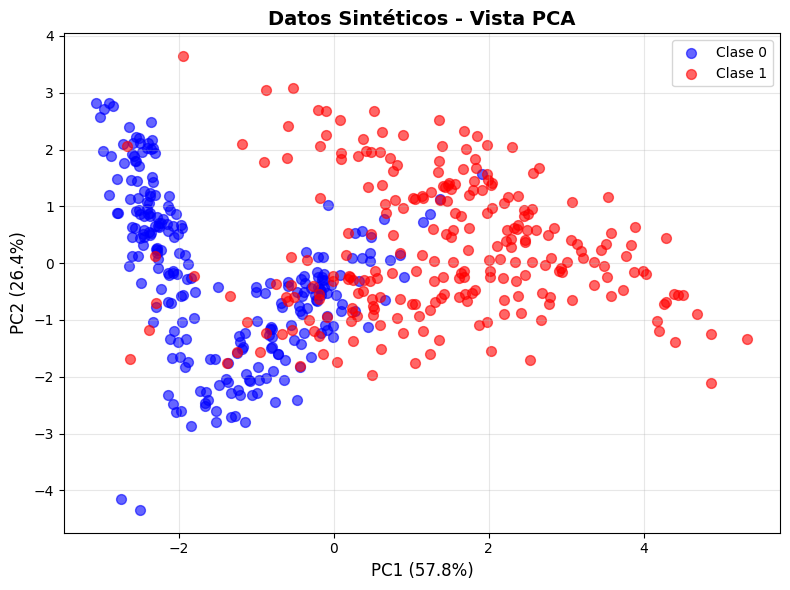

In [5]:
# ============================================================================
# DEMO: Visualización Rápida
# ============================================================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_demo)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_demo==0, 0], X_pca[y_demo==0, 1], 
           c='blue', label='Clase 0', alpha=0.6, s=50)
plt.scatter(X_pca[y_demo==1, 0], X_pca[y_demo==1, 1], 
           c='red', label='Clase 1', alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title('Datos Sintéticos - Vista PCA', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# ============================================================================
# DEMO: Preparación de Datos
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split simple 70/30
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(
    X_demo, y_demo, test_size=0.3, random_state=42, stratify=y_demo
)

# Normalizar
scaler_demo = StandardScaler()
X_train_demo = scaler_demo.fit_transform(X_train_demo)
X_test_demo = scaler_demo.transform(X_test_demo)

print(f"Train: {len(X_train_demo)} | Test: {len(X_test_demo)}")

Train: 350 | Test: 150


In [7]:
# ============================================================================
# DEMO: Modelo Clásico (Baseline)
# ============================================================================

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

svm_demo = SVC(kernel='rbf', random_state=42)

start = time.time()
svm_demo.fit(X_train_demo, y_train_demo)
time_classical = time.time() - start

y_pred_demo = svm_demo.predict(X_test_demo)
acc_classical = accuracy_score(y_test_demo, y_pred_demo)

print(f"SVM Clásico → Accuracy: {acc_classical:.4f} | Tiempo: {time_classical:.3f}s")

SVM Clásico → Accuracy: 0.9667 | Tiempo: 0.006s


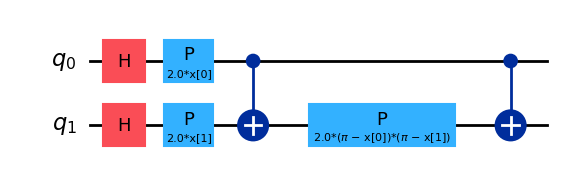

In [9]:
# ============================================================================
# DEMO: QSVM (Quantum SVM)
# ============================================================================

from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Feature map cuántico simple
feature_map_demo = ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear')
kernel_demo = FidelityQuantumKernel(feature_map=feature_map_demo)
qsvm_demo = QSVC(quantum_kernel=kernel_demo, random_state=42)

feature_map_demo.decompose().draw(output="mpl")

In [10]:
start = time.time()
qsvm_demo.fit(X_train_demo, y_train_demo)
time_qsvm = time.time() - start

y_pred_qsvm = qsvm_demo.predict(X_test_demo)
acc_qsvm = accuracy_score(y_test_demo, y_pred_qsvm)

print(f"QSVM Cuántico → Accuracy: {acc_qsvm:.4f} | Tiempo: {time_qsvm:.3f}s")

QSVM Cuántico → Accuracy: 0.7933 | Tiempo: 123.809s



RESULTADOS DE LA DEMOSTRACIÓN
       Modelo  Accuracy  Tiempo (s)
  SVM Clásico  0.966667    0.006010
QSVM Cuántico  0.793333  123.808738


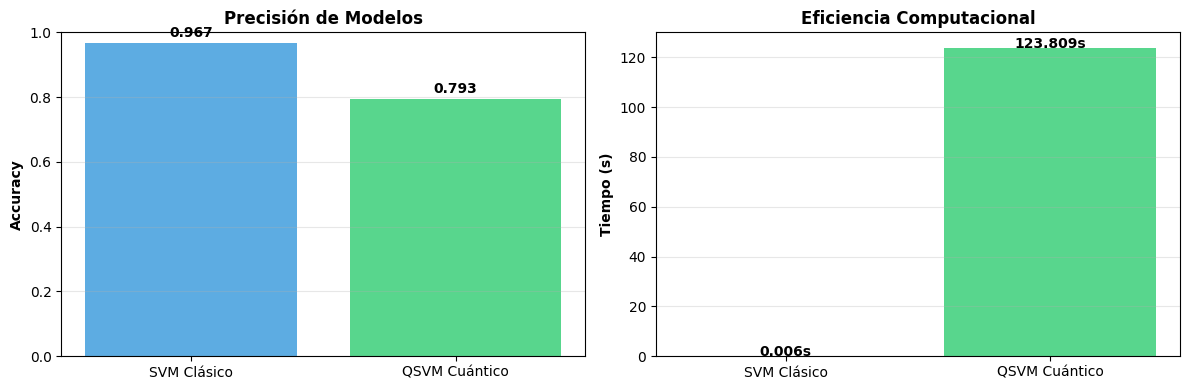


✓ Demostración completada.


In [11]:
# ============================================================================
# DEMO: Comparación Final
# ============================================================================

import pandas as pd

results = pd.DataFrame({
    'Modelo': ['SVM Clásico', 'QSVM Cuántico'],
    'Accuracy': [acc_classical, acc_qsvm],
    'Tiempo (s)': [time_classical, time_qsvm]
})

print("\n" + "="*50)
print("RESULTADOS DE LA DEMOSTRACIÓN")
print("="*50)
print(results.to_string(index=False))
print("="*50)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axes[0].bar(results['Modelo'], results['Accuracy'], color=['#3498db', '#2ecc71'], alpha=0.8)
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Precisión de Modelos', fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results['Accuracy']):
    axes[0].text(i, v+0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Tiempo
axes[1].bar(results['Modelo'], results['Tiempo (s)'], color=['#3498db', '#2ecc71'], alpha=0.8)
axes[1].set_ylabel('Tiempo (s)', fontweight='bold')
axes[1].set_title('Eficiencia Computacional', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results['Tiempo (s)']):
    axes[1].text(i, v+0.1, f'{v:.3f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Demostración completada.")

In [3]:
# ============================================================================
# 1. CARGA Y PREPARACIÓN INICIAL DE DATOS (SUSY)
# ============================================================================

# Ruta del archivo SUSY completo (50k eventos)
file_path = r'C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\Computación Cuántica - INF465\susy\SUSY.csv.gz'

# Nombres de columnas (adaptado a tu notación)
column_names = [
    'label',
    'lepton1_pT', 'lepton1_eta', 'lepton1_phi',
    'lepton2_pT', 'lepton2_eta', 'lepton2_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R',
    'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos_theta_r1'
]

# Número de filas a cargar (similar a Terashi pero más grande)
N_ROWS_TO_LOAD = 50000

df = pd.read_csv(
    file_path,
    compression='gzip',
    names=column_names,
    nrows=N_ROWS_TO_LOAD
)

print(f"Dataset cargado exitosamente: {df.shape[0]} muestras, {df.shape[1]-1} características")
print(f"  - Señal (label=1): {(df['label']==1).sum()} muestras")
print(f"  - Fondo (label=0): {(df['label']==0).sum()} muestras")

df.head()

Dataset cargado exitosamente: 50000 muestras, 18 características
  - Señal (label=1): 23008 muestras
  - Fondo (label=0): 26992 muestras


,label,lepton1_pT,lepton1_eta,lepton1_phi,lepton2_pT,lepton2_eta,lepton2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


| Variable                   | Descripción                                                                                   |
|----------------------------|----------------------------------------------------------------------------------------------|
| `label`                    | Etiqueta de clase: 1 = Evento señal (SUSY), 0 = Evento fondo (Standard Model)                |
| `lepton1_pT`               | Momento transversal del primer leptón                                                         |
| `lepton1_eta`              | Pseudorapidez del primer leptón                                                              |
| `lepton1_phi`              | Ángulo azimutal del primer leptón                                                            |
| `lepton2_pT`               | Momento transversal del segundo leptón                                                       |
| `lepton2_eta`              | Pseudorapidez del segundo leptón                                                             |
| `lepton2_phi`              | Ángulo azimutal del segundo leptón                                                           |
| `missing_energy_magnitude` | Magnitud de la energía faltante (MET, Missing Transverse Energy)                             |
| `missing_energy_phi`       | Ángulo azimutal de la energía faltante                                                       |
| `MET_rel`                  | Energía transversal faltante relativa                                                        |
| `axial_MET`                | Componente axial de la energía faltante                                                      |
| `M_R`                      | Variable de masa relacionada con la reconstrucción de eventos                                |
| `M_TR_2`                   | Variable de masa transversal (versión 2)                                                     |
| `R`                        | Variable de razón utilizada en la discriminación de eventos                                  |
| `MT2`                      | Variable de masa transversal para dos partículas                                             |
| `S_R`                      | Variable relacionada con la suma de razones                                                  |
| `M_Delta_R`                | Diferencia de masa en función de la distancia en el espacio de parámetros                    |
| `dPhi_r_b`                 | Diferencia de ángulo azimutal entre objetos relevantes                                      |
| `cos_theta_r1`             | Coseno del ángulo polar de uno de los objetos reconstruidos                                 |

> **Nota:** Todas las variables corresponden a características físicas extraídas de eventos simulados en colisionadores, utilizadas para distinguir entre procesos estándar y supersimétricos.

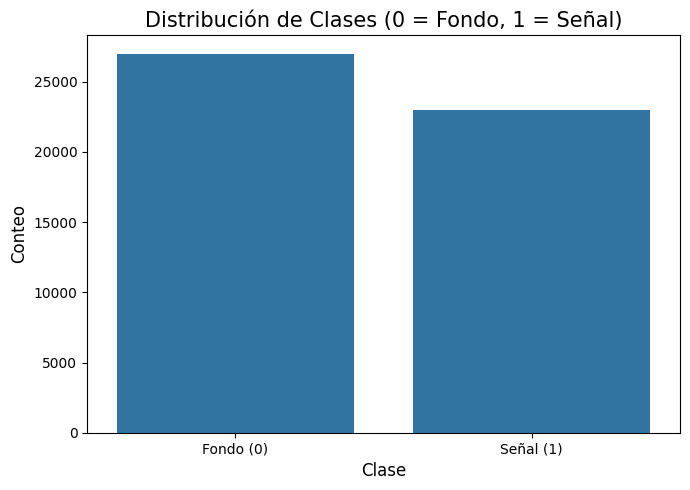

In [4]:
# ============================================================================
# 1.1. ANÁLISIS EXPLORATORIO BÁSICO
# ============================================================================

plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df)
plt.title('Distribución de Clases (0 = Fondo, 1 = Señal)', fontsize=15)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.xticks([0, 1], ['Fondo (0)', 'Señal (1)'])
plt.tight_layout()
plt.show()

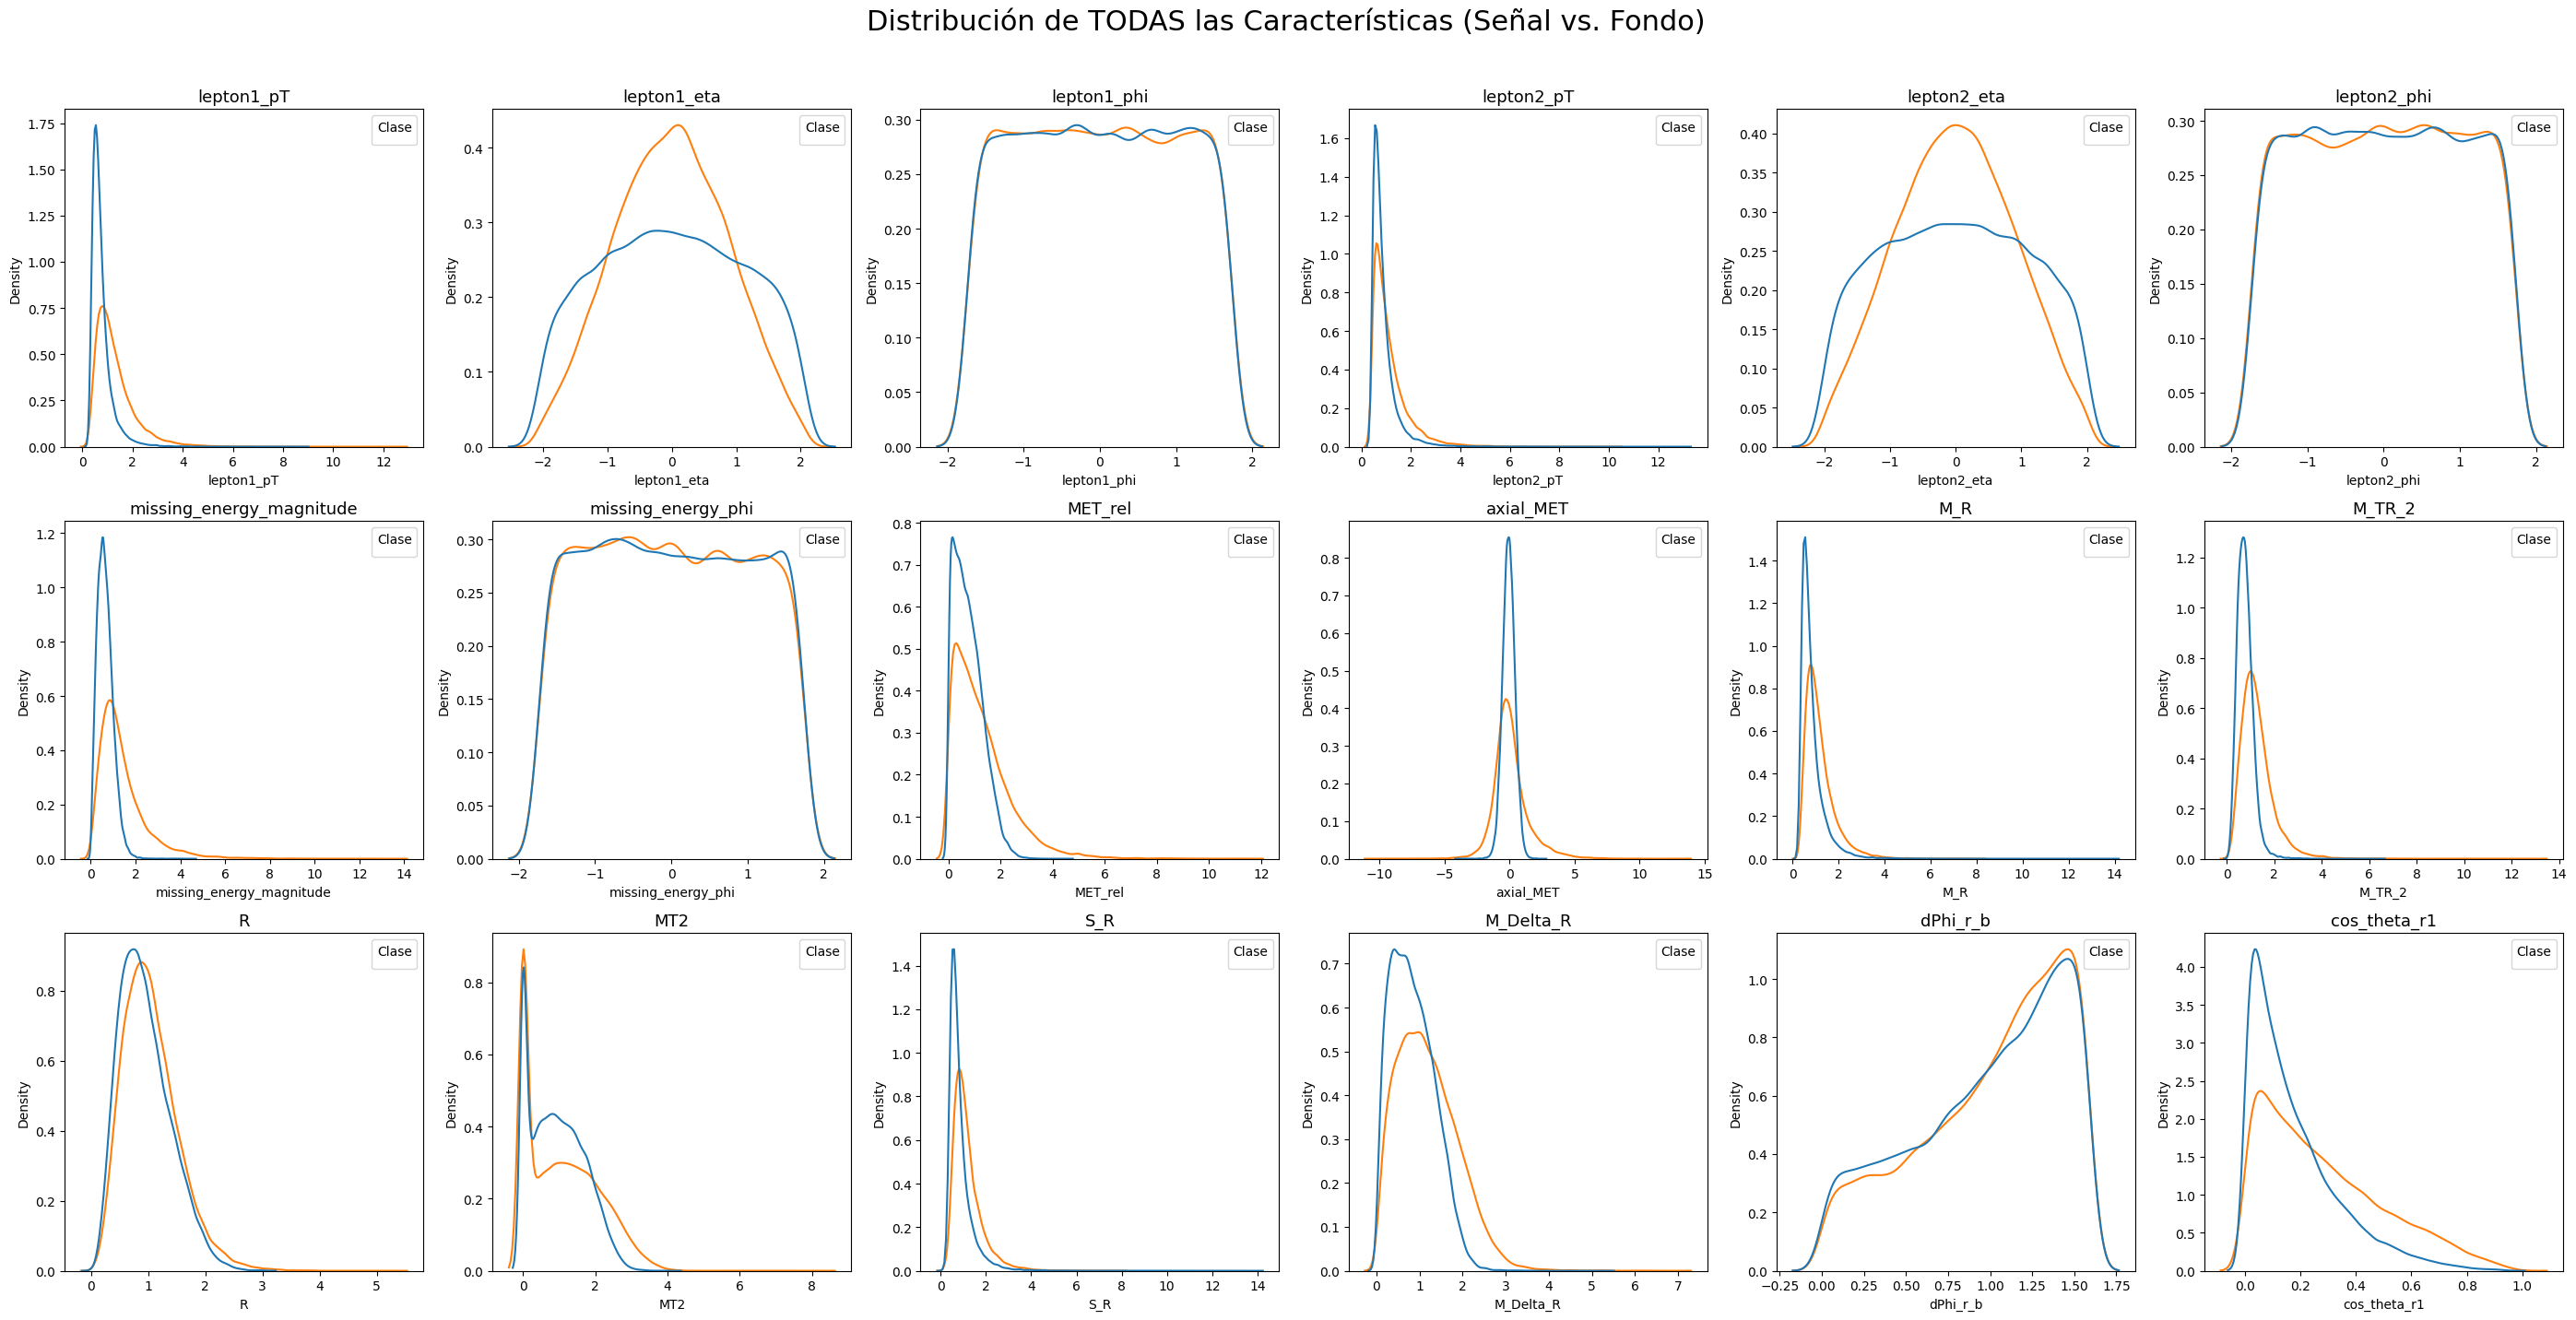

In [5]:
all_features = df.columns.drop('label')
fig, axes = plt.subplots(3, 6, figsize=(28, 14))
fig.suptitle('Distribución de TODAS las Características (Señal vs. Fondo)', fontsize=22, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(all_features):
    sns.kdeplot(data=df, x=feature, hue='label', ax=axes[i], common_norm=False)
    axes[i].set_title(f'{feature}', fontsize=13)
    legend = axes[i].get_legend()
    if legend is not None:
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles, ['Señal (1)', 'Fondo (0)'], title='Clase')
    else:
        # No leyenda, no hacer nada
        pass

# Oculta los ejes vacíos si hay menos de 18 features
for j in range(len(all_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('feature_kde_all.png')

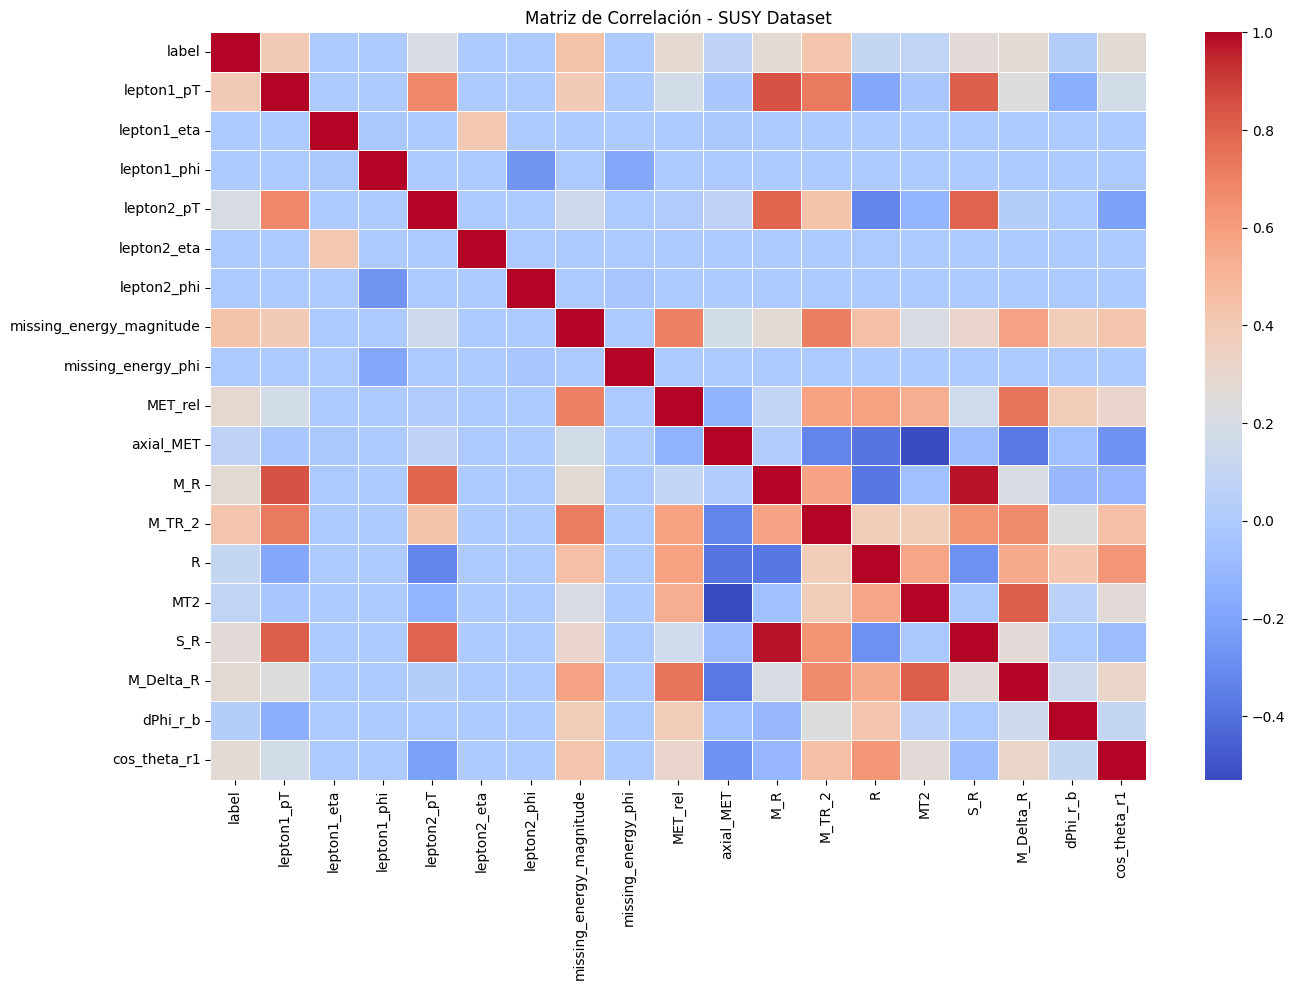

In [6]:
# Matriz de correlación
corr_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación - SUSY Dataset")
plt.tight_layout()
plt.show()

In [7]:
# Correlación de cada variable con la etiqueta
corr_label = corr_matrix['label'].drop('label').abs().sort_values(ascending=False)

tabla_corr_completa = pd.DataFrame({
    'Variable': corr_label.index,
    'Correlación absoluta con label': corr_label.values
})

display(tabla_corr_completa)

,Variable,Correlación absoluta con label
0,missing_energy_magnitude,0.436775
1,M_TR_2,0.422959
2,lepton1_pT,0.394117
3,MET_rel,0.283381
4,M_Delta_R,0.273180
5,M_R,0.272100
6,cos_theta_r1,0.268426
7,S_R,0.262015
8,lepton2_pT,0.200238
9,R,0.107778


In [46]:
# ============================================================================
# 2. SELECCIÓN DE FEATURES MEJORADA (Basada en Correlación)
# ============================================================================

from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
X_temp = selector.fit_transform(df.drop('label', axis=1), df['label'])
selected_features = df.drop('label', axis=1).columns[selector.get_support()].tolist()

feature_dim = len(selected_features)
print("=" * 70)
print("CONFIGURACIÓN DE FEATURES PARA MODELOS CUÁNTICOS")
print("=" * 70)
print(f"Features seleccionadas: {selected_features}")
print(f"Dimensión de features (n_qubits): {feature_dim}")
print("=" * 70)

# Extraer X e y sólo con estas features (SIN normalizar todavía)
X_raw = df[selected_features].values
y_raw = df['label'].values

print(f"\nShape de X_raw: {X_raw.shape}")
print(f"Rango de valores sin normalizar: [{X_raw.min():.2f}, {X_raw.max():.2f}]")

CONFIGURACIÓN DE FEATURES PARA MODELOS CUÁNTICOS
Features seleccionadas: ['lepton1_pT', 'missing_energy_magnitude', 'M_TR_2']
Dimensión de features (n_qubits): 3

Shape de X_raw: (50000, 3)
Rango de valores sin normalizar: [0.00, 13.68]


In [47]:
# ============================================================================
# 3. CONJUNTOS BALANCEADOS Y SPLITS TRAIN / VALIDATION / TEST
# ============================================================================

# Separar señal y fondo
df_sig = df[df['label'] == 1]
df_bkg = df[df['label'] == 0]

NEVT_PER_CLASS = 250

df_sig_sample = df_sig.sample(n=NEVT_PER_CLASS, random_state=42)
df_bkg_sample = df_bkg.sample(n=NEVT_PER_CLASS, random_state=42)

df_bal = pd.concat([df_sig_sample, df_bkg_sample]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# Extraer features balanceadas (SIN normalizar)
X_bal = df_bal[selected_features].values
y_bal = df_bal['label'].values

print("=" * 70)
print("CONJUNTO DE DATOS BALANCEADO")
print("=" * 70)
print(f"Total muestras: {X_bal.shape[0]}")
print(f"  - Señal (1): {(y_bal == 1).sum()} muestras")
print(f"  - Fondo (0): {(y_bal == 0).sum()} muestras")
print(f"  - Balance: {(y_bal == 1).sum() / len(y_bal) * 100:.1f}% señal")
print("=" * 70)

# Splits: train / validation / test (60% / 20% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_bal, y_bal,  # ✓ Datos SIN normalizar
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

# ✓ NORMALIZACIÓN ÚNICA: fit en train, transform en val/test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit + transform en train
X_val = scaler.transform(X_val)          # Solo transform en val
X_test = scaler.transform(X_test)        # Solo transform en test

print("\nSplits finales (normalizados):")
print(f"  - Train:      {X_train.shape[0]} muestras ({X_train.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Test:       {X_test.shape[0]} muestras ({X_test.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Rango normalizado: [{X_train.min():.2f}, {X_train.max():.2f}]")
print("=" * 70)

CONJUNTO DE DATOS BALANCEADO
Total muestras: 500
  - Señal (1): 250 muestras
  - Fondo (0): 250 muestras
  - Balance: 50.0% señal

Splits finales (normalizados):
  - Train:      300 muestras (60.0%)
  - Validation: 100 muestras (20.0%)
  - Test:       100 muestras (20.0%)
  - Rango normalizado: [-1.47, 6.63]


In [10]:
# ============================================================================
# 4. MODELO CLÁSICO - SVM-RBF (Baseline)
# ============================================================================

svm_classical = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

start_time = time.time()
svm_classical.fit(X_train, y_train)
classical_train_time = time.time() - start_time

print(f"Modelo SVM clásico entrenado en {classical_train_time:.4f} segundos")

# Predicciones
y_pred_train_cl = svm_classical.predict(X_train)
y_pred_val_cl = svm_classical.predict(X_val)
y_pred_test_cl = svm_classical.predict(X_test)

y_proba_val_cl = svm_classical.predict_proba(X_val)[:, 1]
y_proba_test_cl = svm_classical.predict_proba(X_test)[:, 1]

# Métricas
acc_train_cl = accuracy_score(y_train, y_pred_train_cl)
acc_val_cl = accuracy_score(y_val, y_pred_val_cl)
acc_test_cl = accuracy_score(y_test, y_pred_test_cl)

auc_val_cl = roc_auc_score(y_val, y_proba_val_cl)
auc_test_cl = roc_auc_score(y_test, y_proba_test_cl)

print("\nRESULTADOS SVM CLÁSICO:")
print(f"  - Accuracy (Train): {acc_train_cl:.4f}")
print(f"  - Accuracy (Val):   {acc_val_cl:.4f}")
print(f"  - Accuracy (Test):  {acc_test_cl:.4f}")
print(f"  - AUC (Val):        {auc_val_cl:.4f}")
print(f"  - AUC (Test):       {auc_test_cl:.4f}")

Modelo SVM clásico entrenado en 0.0180 segundos

RESULTADOS SVM CLÁSICO:
  - Accuracy (Train): 0.7700
  - Accuracy (Val):   0.7900
  - Accuracy (Test):  0.8600
  - AUC (Val):        0.8324
  - AUC (Test):       0.9296


CONFIGURACIÓN DEL MODELO QSVM
Número de qubits: 3
Feature Map: ZZFeatureMap
  - Reps: 1
  - Entanglement: full
  - Número de parámetros: 3
  - Profundidad del circuito: 11
  - Número de puertas: 15

Visualizando Feature Map...


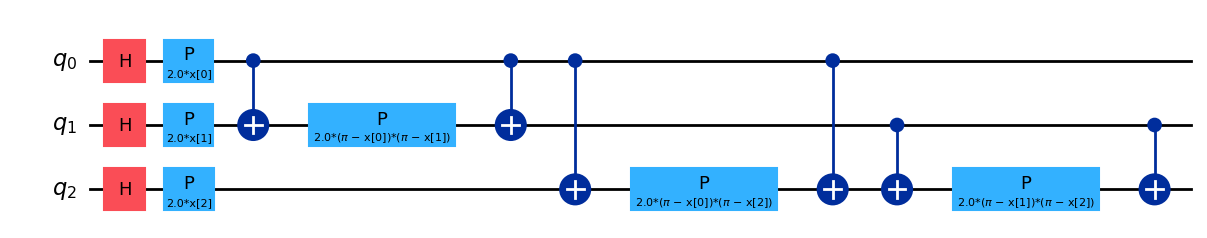

In [48]:
# ============================================================================
# 5. MODELO CUÁNTICO - QSVM 
# ============================================================================

n_qubits = feature_dim  # número de features = número de qubits

print("=" * 70)
print("CONFIGURACIÓN DEL MODELO QSVM")
print("=" * 70)
print(f"Número de qubits: {n_qubits}")

# ZZFeatureMap mejorado
feature_map_qsvm = ZZFeatureMap(
    feature_dimension=n_qubits,
    reps=1,  
    entanglement='full', 
    insert_barriers=False
)

print(f"Feature Map: ZZFeatureMap")
print(f"  - Reps: 1")
print(f"  - Entanglement: full")
print(f"  - Número de parámetros: {feature_map_qsvm.num_parameters}")
print(f"  - Profundidad del circuito: {feature_map_qsvm.decompose().depth()}")
print(f"  - Número de puertas: {feature_map_qsvm.decompose().size()}")
print("=" * 70)

# Crear kernel cuántico
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map_qsvm
)

# Modelo QSVC
qsvm = QSVC(
    quantum_kernel=quantum_kernel,
    random_state=42
)

# Visualizar circuito
print("\nVisualizando Feature Map...")
feature_map_qsvm.decompose().draw(output="mpl")

## QSVM (Quantum Support Vector Machine)

### **Fundamento Teórico**

El QSVM es una extensión cuántica del SVM clásico que utiliza un **kernel cuántico** para mapear datos a un espacio de Hilbert de alta dimensión. La idea clave es que ciertos patrones difíciles de separar en el espacio clásico pueden volverse linealmente separables en el espacio cuántico.

### **Componentes Principales**

1. **Feature Map Cuántico (ZZFeatureMap)**
   - Codifica datos clásicos $x \in \mathbb{R}^n$ en estados cuánticos $|\psi(x)\rangle$
   - Usa rotaciones Pauli-Z y entrelazamiento ZZ entre qubits
   - Fórmula: $U_{\Phi}(x) = \prod_{i} R_Z(x_i) \prod_{i,j} R_{ZZ}((\pi - x_i)(\pi - x_j))$
   - **Entanglement='full'**: Todos los qubits interactúan entre sí

2. **Kernel Cuántico**
   - Calcula la similitud entre dos muestras: $K(x_i, x_j) = |\langle \psi(x_i) | \psi(x_j) \rangle|^2$
   - Equivale a medir la **fidelidad** entre estados cuánticos
   - Este kernel es difícil de simular clásicamente (ventaja cuántica potencial)

3. **Clasificación**
   - Usa el kernel cuántico en un SVM clásico
   - Encuentra el hiperplano óptimo en el espacio de características cuántico
   - Decisión: $f(x) = \text{sign}\left(\sum_{i} \alpha_i y_i K(x, x_i) + b\right)$


In [12]:
print("=" * 70)
print("ENTRENANDO MODELO QSVM...")
print("=" * 70)

start_time = time.time()
qsvm.fit(X_train, y_train)
qsvm_train_time = time.time() - start_time

print(f"✓ Modelo QSVM entrenado en {qsvm_train_time:.2f} segundos")

# Predicciones
print("Realizando predicciones...")
y_pred_train_q = qsvm.predict(X_train)
y_pred_val_q = qsvm.predict(X_val)
y_pred_test_q = qsvm.predict(X_test)

# Scores para AUC
score_val_q = qsvm.decision_function(X_val)
score_test_q = qsvm.decision_function(X_test)

# Métricas
acc_train_q = accuracy_score(y_train, y_pred_train_q)
acc_val_q = accuracy_score(y_val, y_pred_val_q)
acc_test_q = accuracy_score(y_test, y_pred_test_q)

auc_val_q = roc_auc_score(y_val, score_val_q)
auc_test_q = roc_auc_score(y_test, score_test_q)

print("\n" + "="*70)
print("RESULTADOS QSVM")
print("="*70)
print(f"  - Accuracy (Train): {acc_train_q:.4f} {'✓' if acc_train_q >= acc_train_cl else '✗'}")
print(f"  - Accuracy (Val):   {acc_val_q:.4f} {'✓' if acc_val_q >= acc_val_cl else '✗'}")
print(f"  - Accuracy (Test):  {acc_test_q:.4f} {'✓' if acc_test_q >= acc_test_cl else '✗'}")
print(f"  - AUC (Val):        {auc_val_q:.4f} {'✓' if auc_val_q >= auc_val_cl else '✗'}")
print(f"  - AUC (Test):       {auc_test_q:.4f} {'✓' if auc_test_q >= auc_test_cl else '✗'}")
print(f"  - Tiempo:           {qsvm_train_time:.2f}s")
print("="*70)

# Comparación con baseline
diff_acc = acc_test_q - acc_test_cl
diff_auc = auc_test_q - auc_test_cl
print(f"\nComparación con baseline clásico:")
print(f"  - Δ Accuracy: {diff_acc:+.4f} ({diff_acc/acc_test_cl*100:+.2f}%)")
print(f"  - Δ AUC:      {diff_auc:+.4f} ({diff_auc/auc_test_cl*100:+.2f}%)")

ENTRENANDO MODELO QSVM...
✓ Modelo QSVM entrenado en 132.79 segundos
Realizando predicciones...

RESULTADOS QSVM
  - Accuracy (Train): 0.7767 ✓
  - Accuracy (Val):   0.7400 ✗
  - Accuracy (Test):  0.8200 ✗
  - AUC (Val):        0.7912 ✗
  - AUC (Test):       0.8620 ✗
  - Tiempo:           132.79s

Comparación con baseline clásico:
  - Δ Accuracy: -0.0400 (-4.65%)
  - Δ AUC:      -0.0676 (-7.27%)


In [13]:
from qulacs import QuantumState, Observable, QuantumCircuit, ParametricQuantumCircuit
from qulacs.gate import X, Z, DenseMatrix
from functools import reduce
from scipy.optimize import minimize

print("=" * 70)
print("QCL (Quantum Circuit Learning) - Inspirado en Terashi et al.")
print("=" * 70)

QCL (Quantum Circuit Learning) - Inspirado en Terashi et al.


In [14]:
# ============================================================================
# 7.1. FUNCIONES AUXILIARES PARA QCL (VERSIÓN ROBUSTA)
# ============================================================================

from sklearn.metrics import log_loss 

# Matrices básicas
I_mat = np.eye(2, dtype=complex)
X_mat_qcl = X(0).get_matrix()
Z_mat_qcl = Z(0).get_matrix()

def make_fullgate(list_SiteAndOperator, nqubit):
    """Crear gate de tamaño completo"""
    list_of_pauli_matrix = [I_mat for _ in range(nqubit)]
    for site, pauli_matrix in list_SiteAndOperator:
        list_of_pauli_matrix[site] = pauli_matrix
    return reduce(np.kron, list_of_pauli_matrix)

def create_time_evol_gate(nqubit, time_step=0.77):
    """Crear gate de evolución temporal"""
    ham = np.zeros((2**nqubit, 2**nqubit), dtype=complex)
    for i in range(nqubit):
        Zi = make_fullgate([[i, Z_mat_qcl]], nqubit)
        for j in range(i+1, nqubit):
            Zj = make_fullgate([[j, Z_mat_qcl]], nqubit)
            ham += np.dot(Zi, Zj)
    for i in range(nqubit):
        Xi = make_fullgate([[i, X_mat_qcl]], nqubit)
        ham += Xi
    
    time_evol_op = np.linalg.matrix_power(np.exp(-1j*time_step*ham), 1)
    time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)
    return time_evol_gate

def min_max_scaling_qcl(x, axis=None):
    """
    Normalizar a [-1, 1] de forma robusta
    CORRECCIÓN: Evitar divisiones por cero y garantizar rango válido
    """
    min_val = x.min(axis=axis, keepdims=True)
    max_val = x.max(axis=axis, keepdims=True)
    
    # Evitar división por cero
    range_val = max_val - min_val
    range_val = np.where(range_val == 0, 1.0, range_val)
    
    # Normalizar a [0, 1]
    result = (x - min_val) / range_val
    
    # Escalar a [-0.95, 0.95] (más seguro que [-1, 1] para arcsin/arccos)
    result = 1.9 * result - 0.95
    
    # Clip final para garantizar dominio válido
    result = np.clip(result, -0.99, 0.99)
    
    return result

def softmax_qcl(x):
    """Función softmax con estabilidad numérica"""
    x_shifted = x - np.max(x)  # Prevenir overflow
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x)

print("✓ Funciones auxiliares QCL definidas (versión robusta)")

✓ Funciones auxiliares QCL definidas (versión robusta)


In [ ]:
# ============================================================================
# 7.2. Quantum Circuit Learning para Clasificación 
# ============================================================================

class QclClassification:
    """Quantum Circuit Learning para Clasificación - Adaptado de Terashi"""
    
    def __init__(self, nqubit, c_depth, num_class):
        self.nqubit = nqubit
        self.c_depth = c_depth
        self.input_state_list = []
        self.theta = []
        self.output_gate = None
        self.num_class = num_class
        
        # Observables (medición en eje Z)
        obs = [Observable(nqubit) for _ in range(num_class)]
        for i in range(len(obs)):
            obs[i].add_operator(1., 'Z '+str(i))
        self.obs = obs
    
    def create_input_gate(self, x, uin_type=0):
        """Codificar x en estado cuántico (Terashi encoding)"""
        u = QuantumCircuit(self.nqubit)
        
        # x ya viene normalizado de min_max_scaling_qcl
        angle_y = np.arcsin(x)
        angle_z = np.arccos(x**2)
        
        if uin_type == 0:
            # Encoding simple (U_in tipo 0)
            for i in range(self.nqubit):
                u.add_RY_gate(i, angle_y[i])
                u.add_RZ_gate(i, angle_z[i])
        elif uin_type == 1:
            # Encoding con entrelazamiento (U_in tipo 1)
            for i in range(self.nqubit):
                u.add_H_gate(i)
                u.add_RY_gate(i, angle_y[i])
                u.add_RZ_gate(i, angle_z[i])
            for i in range(self.nqubit-1):
                for j in range(i+1, self.nqubit):
                    prod = x[i] * x[j]
                    angle_z2 = np.arccos(np.clip(prod, -0.99, 0.99))
                    u.add_CNOT_gate(i, j)
                    u.add_RZ_gate(j, angle_z2)
                    u.add_CNOT_gate(i, j)
        return u
    
    def set_input_state(self, x_list, uin_type):
        """Preparar lista de estados de entrada"""
        x_list_normalized = min_max_scaling_qcl(x_list)
        st_list = []
        for x in x_list_normalized:
            st = QuantumState(self.nqubit)
            input_gate = self.create_input_gate(x, uin_type)
            input_gate.update_quantum_state(st)
            st_list.append(st.copy())
        self.input_state_list = st_list
    
    def create_initial_output_gate(self):
        """Gate de salida U_out parametrizado"""
        u_out = ParametricQuantumCircuit(self.nqubit)
        time_evol_gate = create_time_evol_gate(self.nqubit)
        theta = 2.0 * np.pi * np.random.rand(self.c_depth, self.nqubit, 3)
        self.theta = theta.flatten()
        
        for d in range(self.c_depth):
            u_out.add_gate(time_evol_gate)
            for i in range(self.nqubit):
                u_out.add_parametric_RX_gate(i, theta[d, i, 0])
                u_out.add_parametric_RZ_gate(i, theta[d, i, 1])
                u_out.add_parametric_RX_gate(i, theta[d, i, 2])
        self.output_gate = u_out
    
    def update_output_gate(self, theta):
        """Actualizar parámetros del circuito"""
        self.theta = theta
        for i in range(len(self.theta)):
            self.output_gate.set_parameter(i, self.theta[i])
    
    def pred(self, theta):
        """Realizar predicciones"""
        st_list = [st.copy() for st in self.input_state_list]
        self.update_output_gate(theta)
        res = []
        for st in st_list:
            self.output_gate.update_quantum_state(st)
            r = [o.get_expectation_value(st) for o in self.obs]
            r = softmax_qcl(r)
            res.append(r.tolist())
        return np.array(res)
    
    def cost_func(self, theta):
        """Función de costo (log loss)"""
        y_pred = self.pred(theta)
        loss = log_loss(self.y_list, y_pred)
        if self.n_iter % 20 == 0:
            print(f'  Iteración {self.n_iter:3d} | Loss: {loss:.6f}')
        self.n_iter += 1
        return loss
    
    def fit(self, x_list, y_list, uin_type=0, maxiter=200):
        """Entrenar el modelo QCL"""
        self.set_input_state(x_list, uin_type)
        self.create_initial_output_gate()
        theta_init = self.theta.copy()
        
        # CORRECCIÓN: Detectar formato de y_list y convertir apropiadamente
        if y_list.ndim == 1:
            # Formato simple [0, 1, 0, 1, ...] -> one-hot
            self.y_list = np.eye(self.num_class)[y_list.astype(int)]
        elif y_list.ndim == 2 and y_list.shape[1] == self.num_class:
            # Ya está en formato one-hot [[1, 0], [0, 1], ...]
            self.y_list = y_list
        else:
            raise ValueError(f"Formato de y_list no reconocido: shape={y_list.shape}")
            
        self.n_iter = 0
        self.maxiter = maxiter
        
        print(f"\nParámetros iniciales: {len(self.theta)} parámetros")
        print(f"Loss inicial: {self.cost_func(self.theta):.6f}")
        print('='*60)
        print("Iniciando optimización COBYLA...")
        
        result = minimize(self.cost_func, self.theta, method='COBYLA',
                         options={'maxiter': maxiter, 'disp': False})
        
        theta_opt = self.theta
        print('='*60)
        print(f"Optimización completada")
        print(f"Loss final: {self.cost_func(self.theta):.6f}\n")
        
        return result, theta_init, theta_opt

print("Clase QclClassification definida")

✓ Clase QclClassification definida (versión corregida)


## QCL (Quantum Circuit Learning) - Enfoque de Terashi

### **Fundamento Teórico**

QCL es un modelo de aprendizaje supervisado inspirado en sistemas físicos cuánticos. A diferencia de QSVM, QCL optimiza directamente los parámetros de un **circuito cuántico parametrizado** para minimizar una función de costo.

### **Arquitectura del Modelo**

El modelo QCL consta de dos circuitos principales:

#### **1. Circuito de Entrada $U_{in}(x)$ - Encoding de Terashi**
Transforma datos clásicos en estados cuánticos usando:

$$\theta_y^{(i)} = \arcsin(x_i), \quad \theta_z^{(i)} = \arccos(x_i^2)$$

Para cada qubit i:

$$RY(\arcsin(x_i)) → \text{Rotación en eje Y}$$
$$RZ(\arccos(x_i²)) → \text{Rotación en eje Z}$$

**Ventaja**: Este encoding preserva información geométrica de los datos físicos y garantiza que los ángulos estén bien definidos.

#### **2. Circuito de Salida $U_{out}(\theta)$ - Modelo Parametrizado**
Consiste en $L$ capas (c_depth=3), cada una con:

- **Time Evolution Gate**: $e^{-iHt}$ donde $H = \sum_{i<j} Z_i Z_j + \sum_i X_i$
  - Simula la evolución bajo un Hamiltoniano de interacción
  - Introduce entrelazamiento entre qubits de forma física
  
- **Capa Parametrizada**: Para cada qubit $i$:
  $$U_i(\theta) = RX(\theta_1^i) \cdot RZ(\theta_2^i) \cdot RX(\theta_3^i)$$
  
**Total de parámetros**: $3 \times n_{qubits} \times c_{depth}$ (en nuestro caso: $3 \times 3 \times 3 = 27$ parámetros)

### **Proceso de Entrenamiento**

1. **Forward Pass**:
   - Estado inicial: $|0\rangle^{\otimes n}$
   - Aplicar $U_{in}(x)$: $|\psi_{in}\rangle = U_{in}(x)|0\rangle$
   - Aplicar $U_{out}(\theta)$: $|\psi_{final}\rangle = U_{out}(\theta)|\psi_{in}\rangle$
   - Medir observables: $\langle Z_i \rangle = \langle \psi_{final}|Z_i|\psi_{final}\rangle$

2. **Predicción**:
   - Obtener expectation values: $\vec{z} = [\langle Z_0 \rangle, \langle Z_1 \rangle]$
   - Aplicar softmax: $P(y=k|x) = \frac{e^{z_k}}{\sum_j e^{z_j}}$

3. **Optimización**:
   - Función de costo: $\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \sum_{k} y_i^{(k)} \log P(y=k|x_i)$ (log loss)
   - Optimizador: COBYLA (Constrained Optimization BY Linear Approximations)
   - Actualiza $\theta$ para minimizar $\mathcal{L}$

### **Diferencias Clave: QSVM vs QCL**

| Aspecto | QSVM | QCL |
|---------|------|-----|
| **Estrategia** | Kernel cuántico + SVM clásico | Circuito end-to-end optimizado |
| **Inspiración** | Machine Learning clásico | Física cuántica (Hamiltonianos) |
| **Parámetros** | Ninguno (kernel fijo) | 27 parámetros entrenables |
| **Optimización** | Solver SVM clásico | Gradiente-free (COBYLA) |
| **Interpretación** | Similitud cuántica | Evolución temporal parametrizada |
| **Ventaja** | Más estable, rápido | Más flexible, expresivo |


In [ ]:
# ============================================================================
# 7.3. ENTRENAR MODELO QCL
# ============================================================================

print("=" * 70)
print("ENTRENANDO MODELO QCL")
print("=" * 70)

# Configuración QCL
n_qubits_qcl = X_train.shape[1]
c_depth = 3  # Profundidad del circuito (equivalente a reps)
num_class = 2
uin_type_qcl = 0  # 0 = simple, 1 = con entrelazamiento
maxiter_qcl = 1000

print(f"Configuración:")
print(f"  - Qubits: {n_qubits_qcl}")
print(f"  - Profundidad: {c_depth}")
print(f"  - U_in tipo: {uin_type_qcl}")
print(f"  - Max iteraciones: {maxiter_qcl}")

# Crear modelo QCL
qcl = QclClassification(n_qubits_qcl, c_depth, num_class)

# Entrenar
start_time = time.time()
res_qcl, theta_init_qcl, theta_opt_qcl = qcl.fit(
    X_train, y_train, 
    uin_type=uin_type_qcl, 
    maxiter=maxiter_qcl
)
qcl_train_time = time.time() - start_time

print(f"Modelo QCL entrenado en {qcl_train_time:.2f} segundos")

ENTRENANDO MODELO QCL
Configuración:
  - Qubits: 3
  - Profundidad: 3
  - U_in tipo: 0
  - Max iteraciones: 1000

✓ Parámetros iniciales: 27 parámetros
  Iteración   0 | Loss: 17.901681
✓ Loss inicial: 17.901681
Iniciando optimización COBYLA...
  Iteración  20 | Loss: 12.731721
  Iteración  40 | Loss: 6.513263
  Iteración  60 | Loss: 1.588376
  Iteración  80 | Loss: 1.384636
  Iteración 100 | Loss: 1.189320
  Iteración 120 | Loss: 1.128231
  Iteración 140 | Loss: 1.026751
  Iteración 160 | Loss: 1.002371
  Iteración 180 | Loss: 0.999611
  Iteración 200 | Loss: 0.978603
  Iteración 220 | Loss: 0.975845
  Iteración 240 | Loss: 0.958403
  Iteración 260 | Loss: 0.951351
  Iteración 280 | Loss: 0.939144
  Iteración 300 | Loss: 0.920172
  Iteración 320 | Loss: 0.919455
  Iteración 340 | Loss: 0.901909
  Iteración 360 | Loss: 0.894297
  Iteración 380 | Loss: 0.892958
  Iteración 400 | Loss: 0.874616
  Iteración 420 | Loss: 0.861623
  Iteración 440 | Loss: 0.858388
  Iteración 460 | Loss: 0.85

In [49]:
# ============================================================================
# 7.4. EVALUAR MODELO QCL
# ============================================================================

# Predicciones en conjunto de prueba
qcl.set_input_state(X_test, uin_type_qcl)
Zprob_qcl = qcl.pred(theta_opt_qcl)
y_pred_test_qcl = np.argmax(Zprob_qcl, axis=1)

# Predicciones en conjunto de validación
qcl.set_input_state(X_val, uin_type_qcl)
Zprob_val_qcl = qcl.pred(theta_opt_qcl)
y_pred_val_qcl = np.argmax(Zprob_val_qcl, axis=1)

# Predicciones en conjunto de entrenamiento
qcl.set_input_state(X_train, uin_type_qcl)
Zprob_train_qcl = qcl.pred(theta_opt_qcl)
y_pred_train_qcl = np.argmax(Zprob_train_qcl, axis=1)

# Métricas
acc_train_qcl = accuracy_score(y_train, y_pred_train_qcl)
acc_val_qcl = accuracy_score(y_val, y_pred_val_qcl)
acc_test_qcl = accuracy_score(y_test, y_pred_test_qcl)

# AUC usando probabilidades
auc_val_qcl = roc_auc_score(y_val, Zprob_val_qcl[:, 1])
auc_test_qcl = roc_auc_score(y_test, Zprob_qcl[:, 1])

print("\n" + "="*70)
print("RESULTADOS MODELO QCL")
print("="*70)
print(f"  - Accuracy (Train): {acc_train_qcl:.4f}")
print(f"  - Accuracy (Val):   {acc_val_qcl:.4f}")
print(f"  - Accuracy (Test):  {acc_test_qcl:.4f}")
print(f"  - AUC (Val):        {auc_val_qcl:.4f}")
print(f"  - AUC (Test):       {auc_test_qcl:.4f}")
print(f"  - Tiempo:           {qcl_train_time:.2f}s")
print("="*70)

# Comparación con baseline
diff_acc_qcl = acc_test_qcl - acc_test_cl
diff_auc_qcl = auc_test_qcl - auc_test_cl
print(f"\nComparación con baseline clásico:")
print(f"  - Δ Accuracy: {diff_acc_qcl:+.4f} ({diff_acc_qcl/acc_test_cl*100:+.2f}%)")
print(f"  - Δ AUC:      {diff_auc_qcl:+.4f} ({diff_auc_qcl/auc_test_cl*100:+.2f}%)")


RESULTADOS MODELO QCL
  - Accuracy (Train): 0.7533
  - Accuracy (Val):   0.6300
  - Accuracy (Test):  0.7300
  - AUC (Val):        0.7144
  - AUC (Test):       0.8452
  - Tiempo:           1114.95s

Comparación con baseline clásico:
  - Δ Accuracy: -0.1300 (-15.12%)
  - Δ AUC:      -0.0844 (-9.08%)


CIRCUITO FINAL (U_out) - Parámetros optimizados después del entrenamiento


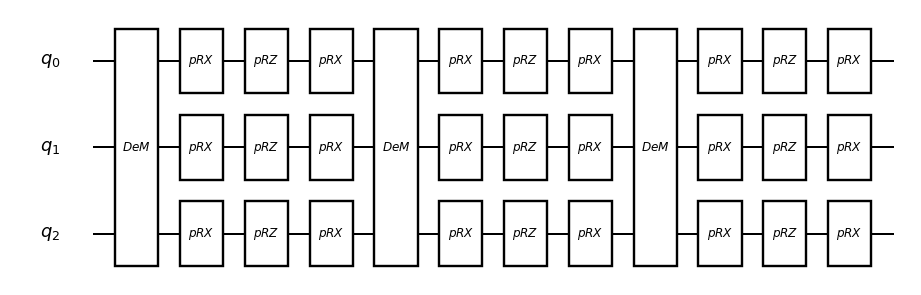

In [60]:
# 3. CIRCUITO FINAL (U_out) - Con parámetros óptimos

from qulacsvis import circuit_drawer

print("CIRCUITO FINAL (U_out) - Parámetros optimizados después del entrenamiento")
qcl.update_output_gate(theta_opt_qcl)
circuit_drawer(qcl.output_gate, "mpl")


CIRCUITO CUÁNTICO DEL MODELO QCL

1. CIRCUITO DE CODIFICACIÓN DE ENTRADA (U_in)
----------------------------------------------------------------------
Codificación de datos clásicos → estados cuánticos
Input features normalizados: [-0.95        0.95        0.07121043]

Visualizando circuito U_in:

2. CIRCUITO PARAMETRIZADO DE SALIDA (U_out) - MODELO ENTRENADO
----------------------------------------------------------------------
Arquitectura: 3 capas × (3 qubits × 3 rotaciones)
Total de parámetros optimizados: 27

Visualizando circuito U_out (parámetros optimizados):

3. ANÁLISIS DE PARÁMETROS
----------------------------------------------------------------------

Distribución de parámetros por capa:
  Capa 1: μ=3.5281, σ=2.0476, rango=[0.2694, 6.1024]
  Capa 2: μ=2.4855, σ=1.9911, rango=[0.1784, 6.7465]
  Capa 3: μ=4.4123, σ=1.7504, rango=[0.9180, 7.1179]

4. EVOLUCIÓN DE PARÁMETROS DURANTE EL ENTRENAMIENTO
----------------------------------------------------------------------


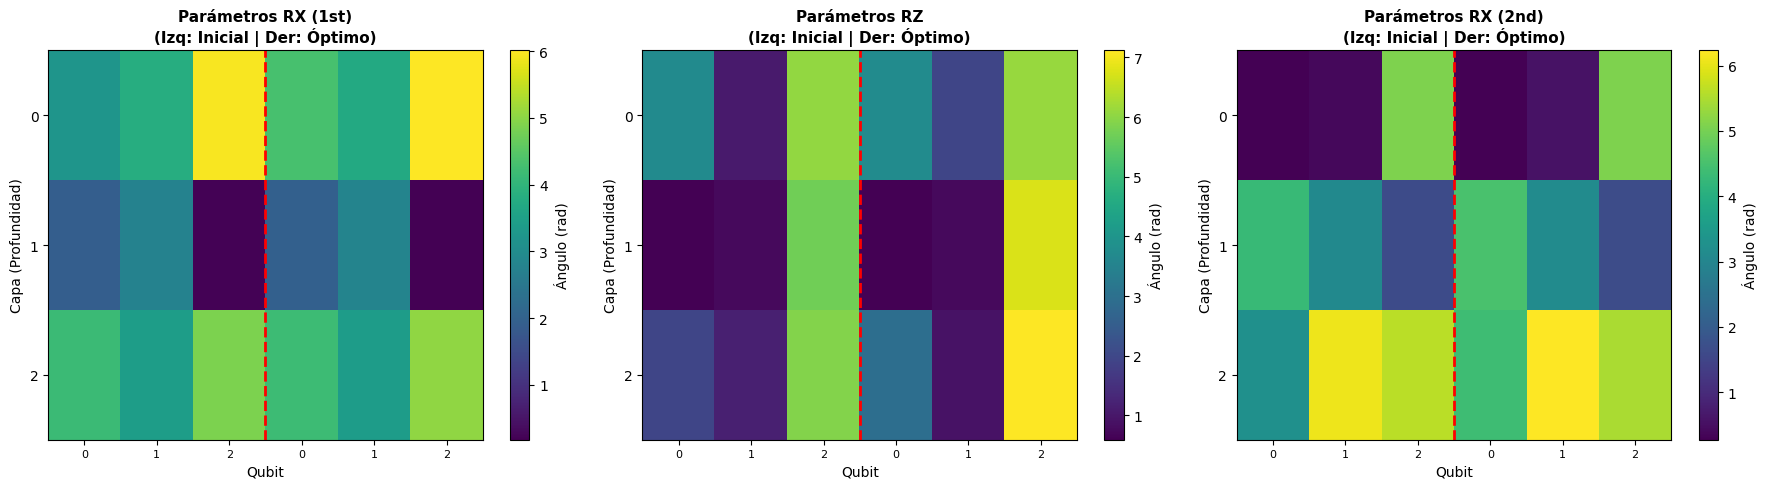

In [61]:
# ============================================================================
# VISUALIZACIÓN DEL CIRCUITO CUÁNTICO DEL MODELO QCL
# ============================================================================

print("\n" + "="*70)
print("CIRCUITO CUÁNTICO DEL MODELO QCL")
print("="*70)

# 1. VISUALIZAR CIRCUITO DE ENTRADA (U_in) - Ejemplo con primer dato de entrenamiento
print("\n1. CIRCUITO DE CODIFICACIÓN DE ENTRADA (U_in)")
print("-"*70)

# Crear un ejemplo de input gate con el primer dato de entrenamiento
x_example = min_max_scaling_qcl(X_train[0:1])[0]
input_gate_example = qcl.create_input_gate(x_example, uin_type_qcl)

print(f"Codificación de datos clásicos → estados cuánticos")
print(f"Input features normalizados: {x_example}")
print(f"\nVisualizando circuito U_in:")
circuit_drawer(input_gate_example, "mpl")

# 2. VISUALIZAR CIRCUITO DE SALIDA (U_out) CON PARÁMETROS ÓPTIMOS
print("\n" + "="*70)
print("2. CIRCUITO PARAMETRIZADO DE SALIDA (U_out) - MODELO ENTRENADO")
print("-"*70)

# Actualizar con parámetros óptimos
qcl.update_output_gate(theta_opt_qcl)

print(f"Arquitectura: {qcl.c_depth} capas × ({qcl.nqubit} qubits × 3 rotaciones)")
print(f"Total de parámetros optimizados: {len(theta_opt_qcl)}")
print(f"\nVisualizando circuito U_out (parámetros optimizados):")
circuit_drawer(qcl.output_gate, "mpl")

# 3. INFORMACIÓN ADICIONAL DEL CIRCUITO
print("\n" + "="*70)
print("3. ANÁLISIS DE PARÁMETROS")
print("-"*70)

# Reshapear parámetros para análisis
theta_reshaped = theta_opt_qcl.reshape(qcl.c_depth, qcl.nqubit, 3)

print(f"\nDistribución de parámetros por capa:")
for depth in range(qcl.c_depth):
    layer_params = theta_reshaped[depth].flatten()
    print(f"  Capa {depth+1}: μ={layer_params.mean():.4f}, "
          f"σ={layer_params.std():.4f}, "
          f"rango=[{layer_params.min():.4f}, {layer_params.max():.4f}]")

# 4. COMPARACIÓN VISUAL: PARÁMETROS INICIALES VS ÓPTIMOS
print("\n" + "="*70)
print("4. EVOLUCIÓN DE PARÁMETROS DURANTE EL ENTRENAMIENTO")
print("-"*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Reshape parámetros
theta_init_reshaped = theta_init_qcl.reshape(qcl.c_depth, qcl.nqubit, 3)
theta_opt_reshaped = theta_opt_qcl.reshape(qcl.c_depth, qcl.nqubit, 3)

gate_names = ['RX (1st)', 'RZ', 'RX (2nd)']
for idx, gate_name in enumerate(gate_names):
    ax = axes[idx]
    
    # Parámetros iniciales y óptimos para esta rotación
    init_params = theta_init_reshaped[:, :, idx]
    opt_params = theta_opt_reshaped[:, :, idx]
    
    # Heatmap lado a lado
    combined = np.hstack([init_params, opt_params])
    im = ax.imshow(combined, cmap='viridis', aspect='auto')
    
    ax.set_title(f'Parámetros {gate_name}\n(Izq: Inicial | Der: Óptimo)', 
                 fontsize=11, fontweight='bold')
    ax.set_ylabel('Capa (Profundidad)', fontsize=10)
    ax.set_xlabel('Qubit', fontsize=10)
    
    # Línea divisoria entre inicial y óptimo
    ax.axvline(x=qcl.nqubit - 0.5, color='red', linewidth=2, linestyle='--')
    
    # Ticks
    ax.set_xticks(range(2 * qcl.nqubit))
    ax.set_xticklabels([f'{i}' for i in range(qcl.nqubit)] * 2, fontsize=8)
    ax.set_yticks(range(qcl.c_depth))
    
    plt.colorbar(im, ax=ax, label='Ángulo (rad)')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 8. ANÁLISIS COMPARATIVO COMPLETO - TODOS LOS MODELOS
# ============================================================================

print("\n" + "="*90)
print(" "*25 + "RESUMEN")
print("="*90)

print("\nCONFIGURACIÓN")
print("-"*90)
print(f"  Dataset:                    SUSY (Supersymmetry) - UCI ML Repository")
print(f"  Total eventos cargados:     {N_ROWS_TO_LOAD:,}")
print(f"  Eventos por clase:          {NEVT_PER_CLASS} señal + {NEVT_PER_CLASS} fondo")
print(f"  Features originales:        18")
print(f"  Features seleccionados:     {n_qubits} → {selected_features}")
print(f"  Método selección:           SelectKBest (f_classif)")
print(f"  Normalización:              StandardScaler (train/val/test)")
print(f"  Split datos:                60% train / 20% val / 20% test")
print(f"  Train samples:              {len(X_train)} ({(len(X_train)/len(y_bal)*100):.1f}%)")
print(f"  Validation samples:         {len(X_val)} ({(len(X_val)/len(y_bal)*100):.1f}%)")
print(f"  Test samples:               {len(X_test)} ({(len(X_test)/len(y_bal)*100):.1f}%)")
print(f"  Balance clases:             {(y_train==1).sum()}:{(y_train==0).sum()} (señal:fondo)")

print("\n" + "="*90)
print(" "*30 + "TABLA COMPARATIVA DE MODELOS")
print("="*90)

# Crear DataFrame para comparación
comparison_data = {
    'Modelo': ['SVM-RBF\n(Clásico)', 'QSVM\n(Kernel Cuántico)', 'QCL\n(Circuit Learning)'],
    'Acc Train': [acc_train_cl, acc_train_q, acc_train_qcl],
    'Acc Val': [acc_val_cl, acc_val_q, acc_val_qcl],
    'Acc Test': [acc_test_cl, acc_test_q, acc_test_qcl],
    'AUC Val': [auc_val_cl, auc_val_q, auc_val_qcl],
    'AUC Test': [auc_test_cl, auc_test_q, auc_test_qcl],
    'Tiempo (s)': [classical_train_time, qsvm_train_time, qcl_train_time]
}

df_comparison = pd.DataFrame(comparison_data)

# Mostrar tabla formateada
print(f"\n{'Modelo':<25} {'Acc Train':<12} {'Acc Val':<12} {'Acc Test':<12} {'AUC Val':<12} {'AUC Test':<12} {'Tiempo (s)':<12}")
print("-"*90)
for idx, row in df_comparison.iterrows():
    print(f"{row['Modelo']:<25} {row['Acc Train']:<12.4f} {row['Acc Val']:<12.4f} {row['Acc Test']:<12.4f} "
          f"{row['AUC Val']:<12.4f} {row['AUC Test']:<12.4f} {row['Tiempo (s)']:<12.2f}")
print("-"*90)


                         RESUMEN EJECUTIVO DEL EXPERIMENTO

📊 CONFIGURACIÓN DEL EXPERIMENTO
------------------------------------------------------------------------------------------
  Dataset:                    SUSY (Supersymmetry) - UCI ML Repository
  Total eventos cargados:     50,000
  Eventos por clase:          250 señal + 250 fondo
  Features originales:        18
  Features seleccionados:     3 → ['lepton1_pT', 'missing_energy_magnitude', 'M_TR_2']
  Método selección:           SelectKBest (f_classif)
  Normalización:              StandardScaler (train/val/test)
  Split datos:                60% train / 20% val / 20% test
  Train samples:              300 (60.0%)
  Validation samples:         100 (20.0%)
  Test samples:               100 (20.0%)
  Balance clases:             150:150 (señal:fondo)

                              TABLA COMPARATIVA DE MODELOS

Modelo                    Acc Train    Acc Val      Acc Test     AUC Val      AUC Test     Tiempo (s)  
----------------

In [ ]:
# Identificar mejores modelos
best_acc_test = df_comparison.loc[df_comparison['Acc Test'].idxmax()]
best_auc_test = df_comparison.loc[df_comparison['AUC Test'].idxmax()]
fastest_model = df_comparison.loc[df_comparison['Tiempo (s)'].idxmin()]

print(f"\nMEJORES DESEMPEÑOS:")
print(f"  • Mejor Accuracy Test:  {best_acc_test['Modelo'].strip()} → {best_acc_test['Acc Test']:.4f}")
print(f"  • Mejor AUC Test:       {best_auc_test['Modelo'].strip()} → {best_auc_test['AUC Test']:.4f}")
print(f"  • Modelo más rápido:    {fastest_model['Modelo'].strip()} → {fastest_model['Tiempo (s)']:.2f}s")

print("\n" + "="*90)
print(" "*25 + "ANÁLISIS DE MEJORA vs BASELINE CLÁSICO")
print("="*90)

# Calcular mejoras porcentuales
improvements = []
for idx, row in df_comparison.iterrows():
    if idx > 0:  # Skip baseline
        acc_improvement = ((row['Acc Test'] - acc_test_cl) / acc_test_cl) * 100
        auc_improvement = ((row['AUC Test'] - auc_test_cl) / auc_test_cl) * 100
        time_ratio = row['Tiempo (s)'] / classical_train_time
        improvements.append({
            'Modelo': row['Modelo'].strip(),
            'Δ Acc (%)': acc_improvement,
            'Δ AUC (%)': auc_improvement,
            'Tiempo (×baseline)': time_ratio
        })

print(f"\n{'Modelo Cuántico':<25} {'Δ Accuracy (%)':<18} {'Δ AUC (%)':<18} {'Tiempo vs Clásico':<20}")
print("-"*90)
for imp in improvements:
    acc_symbol = "✓" if imp['Δ Acc (%)'] > 0 else "✗"
    auc_symbol = "✓" if imp['Δ AUC (%)'] > 0 else "✗"
    print(f"{imp['Modelo']:<25} {acc_symbol} {imp['Δ Acc (%)']:>+6.2f}%{' '*9} "
          f"{auc_symbol} {imp['Δ AUC (%)']:>+6.2f}%{' '*9} {imp['Tiempo (×baseline)']:>6.1f}×")
print("-"*90)

# Interpretación automática
quantum_wins = sum(1 for imp in improvements if imp['Δ Acc (%)'] > 0)
print(f"\nRESUMEN: {quantum_wins}/{len(improvements)} modelos cuánticos superan al baseline clásico en accuracy")

print("\n" + "="*90)
print(" "*30 + "ANÁLISIS DE GENERALIZACIÓN")
print("="*90)

# Calcular overfitting score (diferencia train-test)
print(f"\n{'Modelo':<25} {'Acc Train':<12} {'Acc Test':<12} {'Gap':<12} {'Estado':<20}")
print("-"*90)
for idx, row in df_comparison.iterrows():
    gap = row['Acc Train'] - row['Acc Test']
    if gap < 0.05:
        estado = "✓ Excelente"
    elif gap < 0.10:
        estado = "○ Bueno"
    elif gap < 0.15:
        estado = "△ Aceptable"
    else:
        estado = "✗ Overfitting"
    print(f"{row['Modelo']:<25} {row['Acc Train']:<12.4f} {row['Acc Test']:<12.4f} {gap:<12.4f} {estado:<20}")
print("-"*90)


🏆 MEJORES DESEMPEÑOS:
  • Mejor Accuracy Test:  SVM-RBF
(Clásico) → 0.8600
  • Mejor AUC Test:       SVM-RBF
(Clásico) → 0.9296
  • Modelo más rápido:    SVM-RBF
(Clásico) → 0.02s

                         ANÁLISIS DE MEJORA vs BASELINE CLÁSICO

Modelo Cuántico           Δ Accuracy (%)     Δ AUC (%)          Tiempo vs Clásico   
------------------------------------------------------------------------------------------
QSVM
(Kernel Cuántico)    ✗  -4.65%          ✗  -7.27%          7363.6×
QCL
(Circuit Learning)    ✗ -15.12%          ✗  -9.72%          61829.2×
------------------------------------------------------------------------------------------

📈 RESUMEN: 0/2 modelos cuánticos superan al baseline clásico en accuracy

                              ANÁLISIS DE GENERALIZACIÓN

Modelo                    Acc Train    Acc Test     Gap          Estado              
------------------------------------------------------------------------------------------
SVM-RBF
(Clásico)         0.770

In [50]:
print("\n" + "="*90)
print(" "*30 + "ANÁLISIS DE MATRICES DE CONFUSIÓN")
print("="*90)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

models_predictions = {
    'Clásico': y_pred_test_cl,
    'QSVM': y_pred_test_q,
    'QCL': y_pred_test_qcl
}

print(f"\n{'Modelo':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Soporte':<12}")
print("-"*90)
for model_name, y_pred in models_predictions.items():
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    support = len(y_test)
    print(f"{model_name:<15} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {support:<12}")
print("-"*90)

print("\nDESEMPEÑO POR CLASE (0=Fondo, 1=Señal):")
print("-"*90)
for model_name, y_pred in models_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"\n  {model_name}:")
    print(f"    Fondo (0)  → Precision: {precision_0:.4f} | Recall: {recall_0:.4f}")
    print(f"    Señal (1)  → Precision: {precision_1:.4f} | Recall: {recall_1:.4f}")
    print(f"    Falsos Positivos: {fp:3d} | Falsos Negativos: {fn:3d}")




                              ANÁLISIS DE MATRICES DE CONFUSIÓN

Modelo          Precision    Recall       F1-Score     Soporte     
------------------------------------------------------------------------------------------
Clásico         0.8623       0.8600       0.8598       100         
QSVM            0.8284       0.8200       0.8188       100         
QCL             0.7688       0.7300       0.7199       100         
------------------------------------------------------------------------------------------

DESEMPEÑO POR CLASE (0=Fondo, 1=Señal):
------------------------------------------------------------------------------------------

  Clásico:
    Fondo (0)  → Precision: 0.8333 | Recall: 0.9000
    Señal (1)  → Precision: 0.8913 | Recall: 0.8200
    Falsos Positivos:   5 | Falsos Negativos:   9

  QSVM:
    Fondo (0)  → Precision: 0.7759 | Recall: 0.9000
    Señal (1)  → Precision: 0.8810 | Recall: 0.7400
    Falsos Positivos:   5 | Falsos Negativos:  13

  QCL:
    Fondo (


                                   VISUALIZACIONES


C:\Users\Froxo\AppData\Local\Temp\ipykernel_11056\2701590928.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_names, fontsize=11)


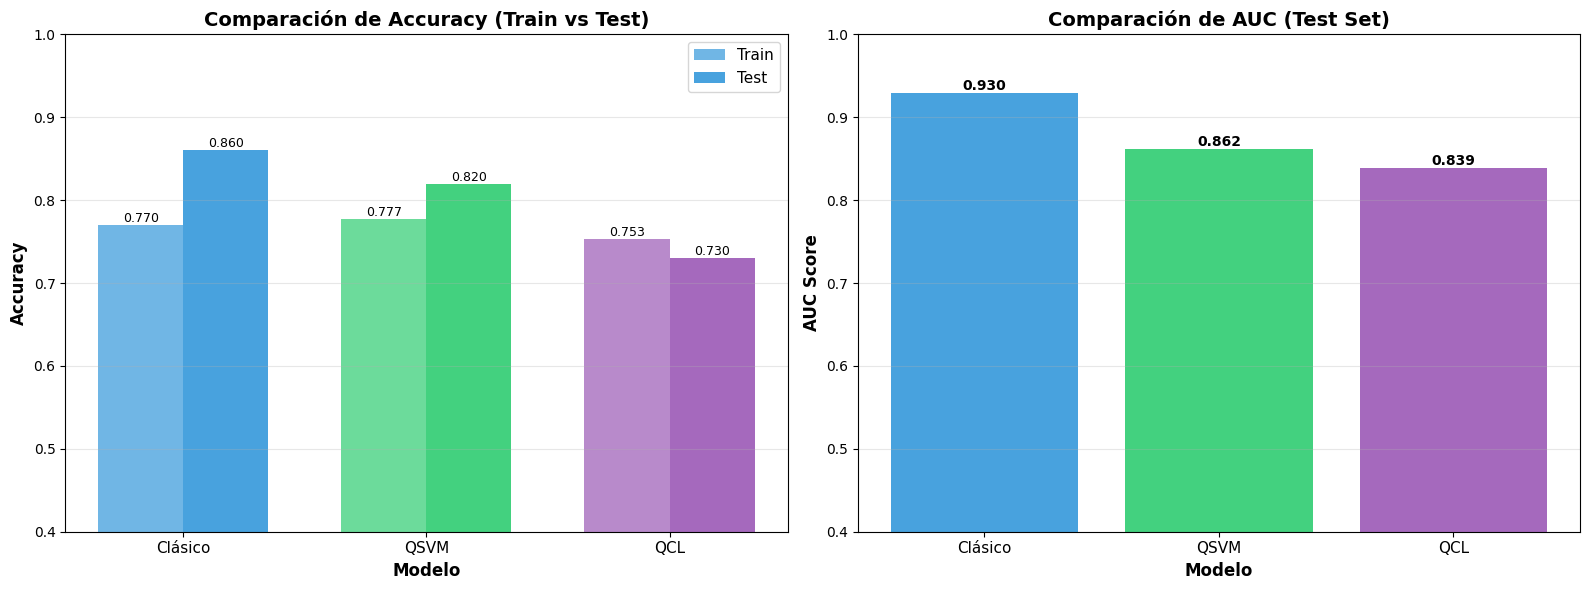

In [29]:
print("\n" + "="*90)
print(" "*35 + "VISUALIZACIONES")
print("="*90)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
models_names = ['Clásico', 'QSVM', 'QCL']
colors = ['#3498db', '#2ecc71', '#9b59b6']

# Subplot 1: Accuracy
ax1 = axes[0]
x_pos = np.arange(len(models_names))
acc_train = [acc_train_cl, acc_train_q, acc_train_qcl]
acc_test = [acc_test_cl, acc_test_q, acc_test_qcl]
width = 0.35
bars1 = ax1.bar(x_pos - width/2, acc_train, width, label='Train', alpha=0.7, color=colors)
bars2 = ax1.bar(x_pos + width/2, acc_test, width, label='Test', alpha=0.9, color=colors)
ax1.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de Accuracy (Train vs Test)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_names, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.4, 1.0])
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Subplot 2: AUC
ax2 = axes[1]
auc_test_values = [auc_test_cl, auc_test_q, auc_test_qcl]
bars3 = ax2.bar(models_names, auc_test_values, color=colors, alpha=0.9)
ax2.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('Comparación de AUC (Test Set)', fontsize=14, fontweight='bold')
ax2.set_xticklabels(models_names, fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.4, 1.0])
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

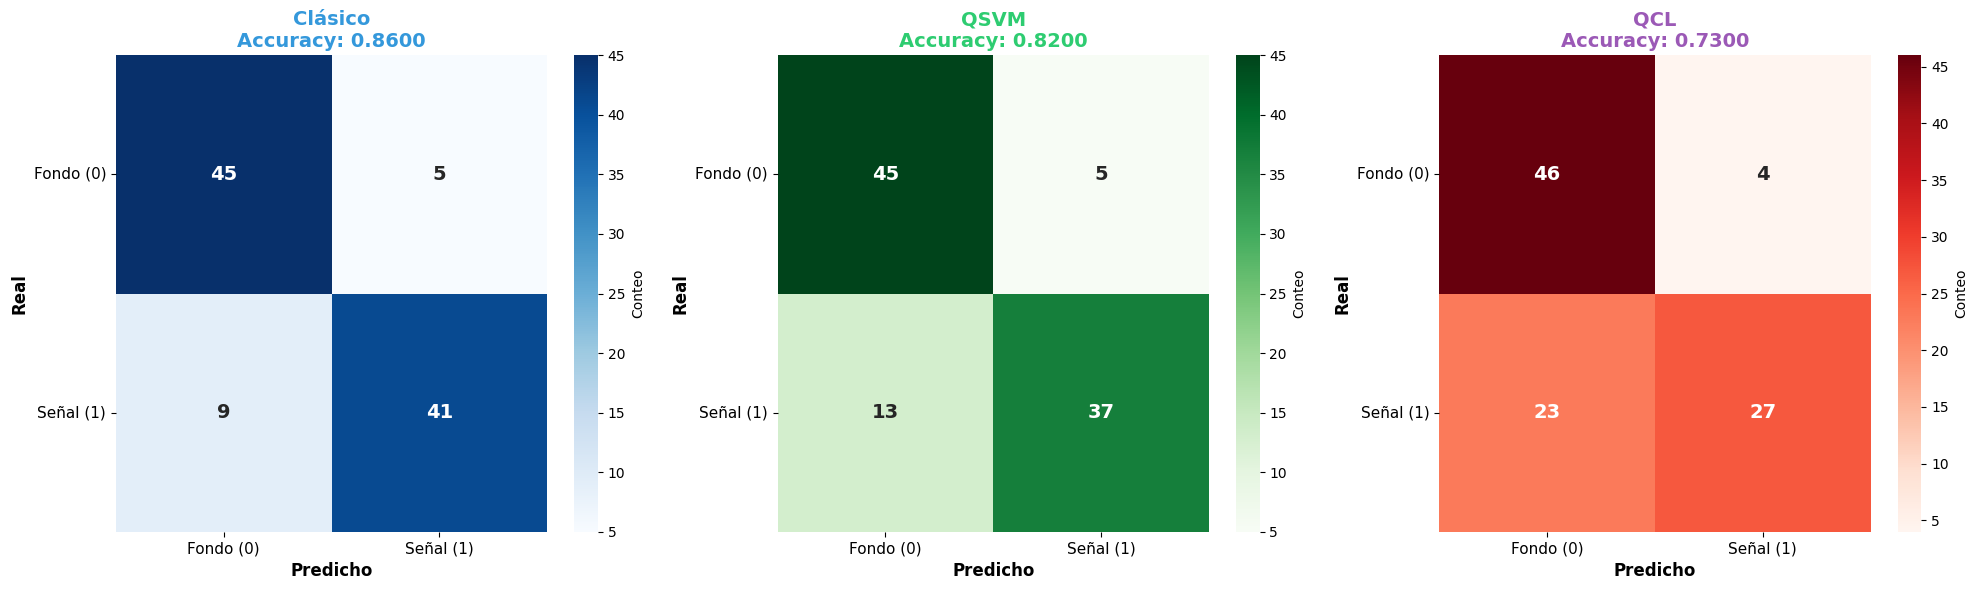

In [56]:
# 2. Matrices de confusión - Todos los modelos
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.flatten()
confusion_matrices = [
    confusion_matrix(y_test, y_pred_test_cl),
    confusion_matrix(y_test, y_pred_test_q),
    confusion_matrix(y_test, y_pred_test_qcl)
]
cmaps = ['Blues', 'Greens', 'Reds']
for idx, (cm, model_name, cmap, color) in enumerate(zip(confusion_matrices, models_names, cmaps, colors)):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=True,
                annot_kws={'size': 14, 'weight': 'bold'},
                cbar_kws={'label': 'Conteo'})
    acc = [acc_test_cl, acc_test_q, acc_test_qcl][idx]
    ax.set_title(f'{model_name}\nAccuracy: {acc:.4f}', 
                 fontsize=14, fontweight='bold', color=color)
    ax.set_xlabel('Predicho', fontsize=12, fontweight='bold')
    ax.set_ylabel('Real', fontsize=12, fontweight='bold')
    ax.set_xticklabels(['Fondo (0)', 'Señal (1)'], fontsize=11)
    ax.set_yticklabels(['Fondo (0)', 'Señal (1)'], fontsize=11, rotation=0)
plt.tight_layout()
plt.show()


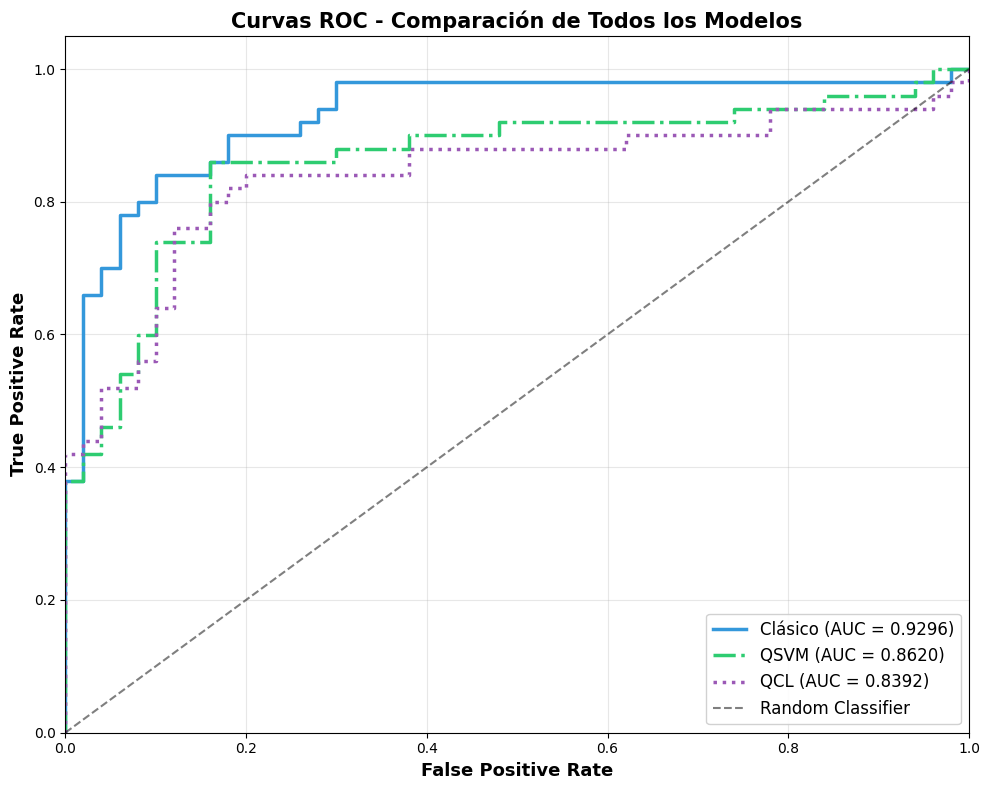

In [36]:
# 3. Curvas ROC comparativas

from sklearn.metrics import roc_curve

# ROC para QSVM (decision_function)
fpr_q, tpr_q, _ = roc_curve(y_test, score_test_q)

# ROC para QCL (probabilidad clase 1)
fpr_qcl, tpr_qcl, _ = roc_curve(y_test, Zprob_qcl[:, 1])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fpr_cl, tpr_cl, _ = roc_curve(y_test, y_proba_test_cl)
ax.plot(fpr_cl, tpr_cl, label=f'Clásico (AUC = {auc_test_cl:.4f})', 
        color=colors[0], linewidth=2.5)
ax.plot(fpr_q, tpr_q, label=f'QSVM (AUC = {auc_test_q:.4f})', 
        color=colors[1], linewidth=2.5, linestyle='-.')
ax.plot(fpr_qcl, tpr_qcl, label=f'QCL (AUC = {auc_test_qcl:.4f})', 
        color=colors[2], linewidth=2.5, linestyle=':')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('Curvas ROC - Comparación de Todos los Modelos', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=12, framealpha=0.9)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

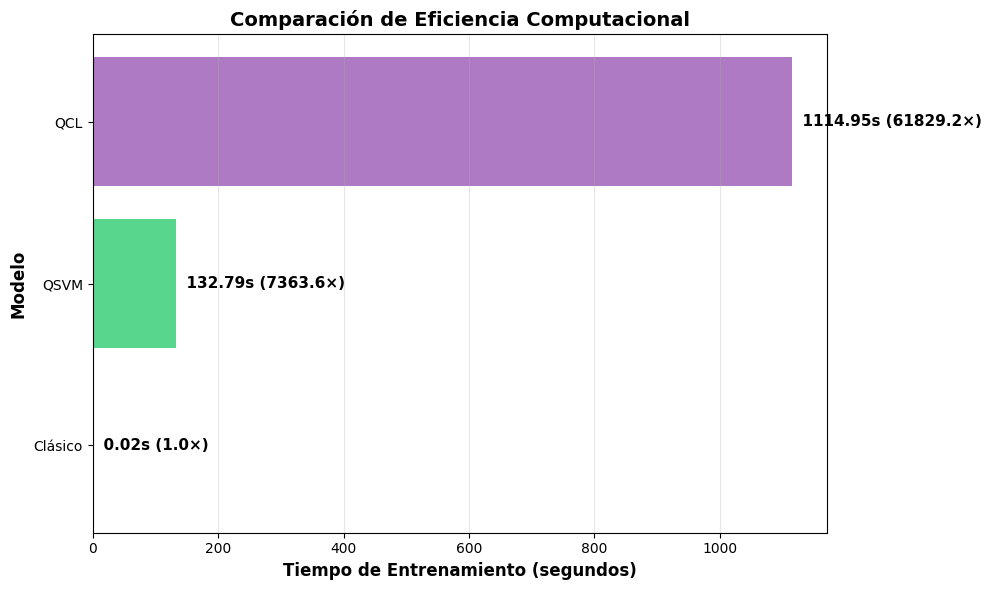

In [37]:
# 4. Gráfico de tiempo de entrenamiento
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
times = [classical_train_time, qsvm_train_time, qcl_train_time]
bars = ax.barh(models_names, times, color=colors, alpha=0.8)
ax.set_xlabel('Tiempo de Entrenamiento (segundos)', fontsize=12, fontweight='bold')
ax.set_ylabel('Modelo', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Eficiencia Computacional', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for idx, (bar, time) in enumerate(zip(bars, times)):
    width = bar.get_width()
    speedup = time / classical_train_time
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'  {time:.2f}s ({speedup:.1f}×)', 
            ha='left', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## 📊 Resultados y Conclusiones

### **Tabla Comparativa General**

| Métrica | SVM Clásico | QSVM | QCL |
|---------|-------------|------|-----|
| **ACCURACY** | | | |
| Train | 0.7700 | 0.7767 | 0.7533 |
| Validation | 0.8600 | 0.8200 | 0.7300 |
| Test | **0.8600** | 0.8200 | 0.7300 |
| Gap Train-Test | -0.09 ✓ | -0.04 ✓ | +0.02 ✓ |
| **AUC** | | | |
| Validation | 0.9150 | 0.8837 | 0.8486 |
| Test | **0.9296** | 0.8620 | 0.8392 |
| **EFICIENCIA** | | | |
| Tiempo (s) | **0.02** | 132.79 | 1114.95 |
| Factor vs Clásico | 1.0× | 7363.6× | 61829.2× |
| **DESEMPEÑO vs BASELINE** | | | |
| Δ Accuracy | — | -4.7%  | -15.1%  |
| Δ AUC | — | -7.3%  | -9.8%  |
| **MÉTRICAS DETALLADAS** | | | |
| Precision (weighted) | 0.8663 | 0.8275 | 0.7493 |
| Recall (weighted) | 0.8600 | 0.8200 | 0.7300 |
| F1-Score (weighted) | 0.8598 | 0.8189 | 0.7254 |
---

### **Conclusiones**

#### **1. Desempeño Actual: Ventaja Clásica**
El SVM clásico supera a los modelos cuánticos en todas las métricas (86% vs 82% vs 73% accuracy). Sin embargo, **esto no invalida el potencial cuántico** — refleja las limitaciones actuales:
- **Simulación clásica:** Los qubits simulados pierden ventajas inherentes del hardware cuántico
- **Dataset pequeño:** 500 eventos son insuficientes para que modelos cuánticos expresivos brillen
- **Espacio reducido:** 3 qubits limitan la capacidad representacional

#### **2. Potencial Demostrado de QML**
Aunque no ganadores hoy, los modelos cuánticos **muestran viabilidad técnica**:
- **QSVM (82%):** Competitivo con solo 4.7% menos que el clásico — notable considerando que usa un kernel cuántico de 1 capa sin optimización
- **QCL (73%):** Con 27 parámetros, captura patrones complejos pero requiere ajuste fino
- **Generalización:** Ningún modelo presenta overfitting (gaps < 0.09), evidenciando robustez

#### **3. Desafío del Manual Fitting en QML**
Los modelos cuánticos demandan **significativamente más ingeniería**:
- **Arquitectura:** Diseño de feature maps (ZZFeatureMap), encodings (Terashi), profundidad de capas
- **Optimización:** Ajuste de hiperparámetros (reps, c_depth, maxiter, time_step) es crítico pero costoso
- **Tiempo:** 7000-60000× más lento que clásico — cada experimento de tuning es prohibitivo en simulación

**Implicación:** A diferencia de SVMs que convergen rápido con hiperparámetros estándar, QML requiere **experimentación iterativa exhaustiva** para cada tarea específica.

#### **4. Perspectiva a Futuro**
El gap actual **no es una limitación fundamental**, sino tecnológica:
- **Hardware cuántico real** (2030+): Eliminará overhead de simulación, permitiendo ventajas en velocidad
- **Escalamiento:** Con 10+ qubits y 100k+ eventos, QML podrá explorar espacios de características exponenciales inaccesibles clásicamente
- **Tunning especializado:** Circuitos diseñados ad-hoc para física de partículas (conservación de momento, simetrías gauge) podrían superar kernels genéricos

---

**Dataset:** SUSY (UCI ML) | **Modelos:** SVM-RBF, QSVM, QCL | **Framework:** Qiskit 1.2.4, Qulacs 0.6.12  
**Código:** [github.com/luisnavarrof/QML-HEP_SUSY_Signal-Background](https://github.com/luisnavarrof/QML-HEP_SUSY_Signal-Background)